In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.io import read_image
torch.manual_seed(0)


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL,cv2
from PIL import Image,ImageOps,ImageDraw
import os
from tqdm import tqdm,trange
import time

import albumentations

In [3]:
#create an annotation file for the labels
default_dir = "/content/drive/MyDrive/Coding Stuffs/Repository/Personal datasets/nose_mask_recognition/"
os.chdir(default_dir) #this will be the default working directory for this work.

print("Working Directory \n",os.getcwd())
training_path = "Training_data"
testing_path = "Testing_data"
validation_path = "VAL"

Working Directory 
 /content/drive/MyDrive/Coding Stuffs/Repository/Personal datasets/nose_mask_recognition


In [4]:
labels_map = {"no_mask":0,
              "incorrectly_masked":1,
              "masked":2}

In [14]:
def annotation_file(path):
  """generate an annotation file for the images"""
  """path argument takes in the directory of the images"""
           
  images = os.listdir(path)    #get the images in the directory

  annote = []
  for i in tqdm(images):
    if i.startswith("no_mask"):
      annote.append(0)

    elif i.startswith("incorrectly_masked"):
      annote.append(1)

    elif i.startswith("masked"):
      annote.append(2)

    else:
      annote.append(i)

  annotations = pd.DataFrame([images,annote]).T
  annotations = annotations.sample(frac = 1).reset_index(drop = True) #shuffle the dataframe and reset the indices
  print(" Annotations Successful")
  return annotations

In [15]:
#generate an annotatation file for the training images
train_df = annotation_file(path = training_path) #
train_df.head(3)

100%|██████████| 1500/1500 [00:00<00:00, 1276675.32it/s]

 Annotations Successful


,0,1
0,incorrectly_masked (44).jpg,1
1,masked (540).jpg,2
2,incorrectly_masked (366).jpg,1


In [11]:
#generate an annotation file for the testing images
test_df = annotation_file(path = testing_path)
test_df.head(3)

100%|██████████| 300/300 [00:00<00:00, 468288.50it/s]

Annotations Successful


,0,1
0,masked (370).jpg,2
1,no_mask (172).png,0
2,incorrectly_masked (171).jpg,1


In [13]:
#generate an annotation file for the validation images
val_df = annotation_file(path = validation_path)
val_df.head(3)

100%|██████████| 300/300 [00:00<00:00, 667528.49it/s]

Annotations Successful


,0,1
0,incorrectly_masked (352).jpg,1
1,no_mask (105).png,0
2,masked (96).jpg,2


In [22]:
def sample_images(path,annotation_file):
  os.chdir(os.path.join(os.getcwd(),path))
  print(os.getcwd())
  for i in tqdm(range(16)):
    plt.subplot(4,4,i+1)
    image = plt.imread(annotation_file.iloc[i,0])
    plt.imshow(image)
    plt.xticks([]) ; plt.yticks([])
  os.chdir(default_dir) #restore to the working directory

/content/drive/My Drive/Coding Stuffs/Repository/Personal datasets/nose_mask_recognition/Training_data


100%|██████████| 16/16 [00:00<00:00, 18.50it/s]


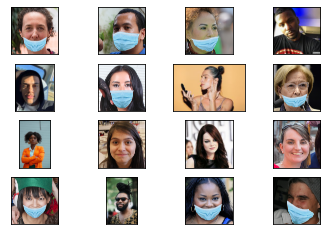

In [23]:
sample_images(training_path,train_df)

In [24]:
class NoseMask(torch.utils.data.Dataset):
  def __init__(self,annotation_file,img_dir,transform = None):
    self.transform = transform
    self.annotation_file = annotation_file
    self.img_dir = img_dir
    self.classes = labels_map#annotation_file[1].unique()
  def __len__(self):
    return len(self.annotation_file)

  def __getitem__(self,idx):
    image_path = os.path.join(self.img_dir,self.annotation_file.iloc[idx,0])
    img = Image.open(image_path)

    if self.transform:
      img = self.transform(img)

    return img,self.annotation_file.iloc[idx,1]

In [25]:
#construct an image transformer
from torchvision import transforms
#Augment the training images for model generalization
training_transforms = torchvision.transforms.Compose([(transforms.Resize((224,224))),
                                                    (transforms.RandomRotation(30)),
                                                   (transforms.RandomHorizontalFlip()),
                                                    #(transforms.RandomChoice([transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip()], p=0.5)),
                                                    (transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5))),
                                                    (transforms.ToTensor()),
                                                    (transforms.Normalize(mean = (0.485,0.456,0.406),std =(0.229,0.224,0.225)))])
#define a transformation for the validation datasets
validation_transforms = transforms.Compose([transforms.Resize(224),
                                            transforms.CenterCrop(200),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

#define a transformation for the validation_images
testing_transforms = transforms.Compose([transforms.Resize(224),
                                         transforms.CenterCrop(200),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

In [26]:
training_data = NoseMask(annotation_file=train_df,img_dir = training_path,transform = training_transforms)
testing_data = NoseMask(annotation_file = test_df, img_dir =  testing_path,transform = testing_transforms)
validation_data = NoseMask(annotation_file = val_df,img_dir = validation_path,transform = validation_transforms)

In [27]:
def show_transformed_images(dataset):
  img_loader = torch.utils.data.DataLoader(dataset,batch_size = 9)
  img_grid = next(iter(img_loader))
  images,labels = img_grid
  torch_grid = torchvision.utils.make_grid(images,nrow = 3)
  plt.imshow(np.transpose(torch_grid,[1,2,0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


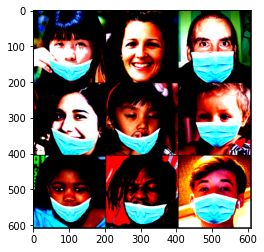

In [28]:
show_transformed_images(dataset = validation_data)

In [29]:
training_dataloader = torch.utils.data.DataLoader(dataset = training_data,batch_size=64,shuffle = True)
validation_dataloader = torch.utils.data.DataLoader(dataset = validation_data,batch_size =64)
testing_dataloader = torch.utils.data.DataLoader(dataset = testing_data,batch_size = 64)

In [30]:
#dsets = torchvision.datasets.ImageFolder(os.path.join(default_dir,"remainder"))
#Image.open(dsets.imgs[0][0])

In [31]:
from torchvision.models import vgg16
model = vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [32]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [45]:
for params in model.parameters():
  params.requires_grad = False
print("\n Operation Successful")


 Operation Successful


In [46]:
#obtain the input and out_features value for the last layer 
in_features = model.classifier[6].out_features #this will be used as the input feature for our custom last layer
out_features = len(training_dataloader.dataset.classes) #this will be used as the output features for our custom last layer

In [47]:
#construct the last layer by adding one additional layer to the vgg16 model architecture
model.classifier.add_module("last_layer",torch.nn.Linear(in_features = in_features,out_features = 3))

In [48]:
model.classifier.last_layer.requires_grad_(True)

Linear(in_features=1000, out_features=3, bias=True)

In [49]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

print(torch.__version__)
print(torch.version.cuda)

cuda
0
Tesla K80
1.10.0+cu111
11.1


In [50]:
#lets move the model to cuda
model = model.to(device)

In [51]:
#optimizer and loss function
learning_rate = 0.004
optimizer = torch.optim.Adam(params = model.parameters(),lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [55]:
next(iter(training_dataloader));

In [57]:
for image,label in training_dataloader:
  #print(image,label)
  print('shape of images :',image.shape)
  print('shape of labels :' ,label.shape)
  break

shape of images : torch.Size([64, 3, 224, 224])
shape of labels : torch.Size([64])


In [ ]:
def training_loop(model,dataloader,optimizer,loss_fn):

  model.train()

  num_batches = len(dataloader)
  data_size = len(dataloader.dataset)

  training_loss,training_accuracy = 0,0          #training loss and accuracy

  for batch,(images,labels) in enumerate(dataloader):
    images = images.type(torch.FloatTensor)
    images = images.to(device)

    labels = labels.type(torch.int64)
    labels= labels.to(device)
    
    #forward pass
    y_pred = model(images)

    loss = loss_fn(y_pred,labels)       #compute the loss
    optimizer.zero_grad()               #empyt/zero the gradient
    loss.backward()                     #do a backpropagation
    optimizer.step()                    #updata the weights

    acc = (y_pred.argmax(1)==labels).sum().type(torch.float).item()
    training_accuracy+= acc
    training_loss+= loss

  training_accuracy/= data_size
  training_loss/= num_batches

  print(f"Training Loss   :::>    {(training_loss):.3f}     ||    Training Accuracy   :::>    {(training_accuracy):.3f}")

In [ ]:
def testing_loop(dataloader,model,loss_fn):

  model.eval()

  num_batches = len(dataloader)
  testing_size = len(dataloader.dataset)

  testing_loss,testing_accuracy = 0,0

  with torch.no_grad():

    for images,labels in dataloader:
        images,labels = images.to(device),labels.to(device)

        y_pred = model(images)                 #make predictions
        loss = loss_fn(y_pred,labels)          #compute the difference between actual outputs and predicted outputs

        batch_accuracy = (y_pred.argmax(1)==labels).sum().type(torch.float).item()        #test models accuracy -- how many were correctly predicted

        testing_loss+= loss                    #sum up the loss obtained from each batch iteration
        testing_accuracy+= batch_accuracy      #sum up the accuracy from each batch iteration

    testing_accuracy/= testing_size            # accuracy = correctly predicted samples/all available samples
    testing_loss/= num_batches                 #compute the cost (average loss) -- total loss/ sum of individual batches

    print(f"Testing Loss    :::>    {(testing_loss):.3f}     ||    Testing Accuracy   :::>    {(testing_accuracy):.3f}")

In [ ]:
num_epochs = 10
import time
start_time = time.time()
for epochs in torch.arange(num_epochs):
  print(f"Epoch {(epochs+1).item()}/{num_epochs}")
  training_loop(model,training_dataloader,optimizer,loss_fn)
  testing_loop(testing_dataloader,model,loss_fn)
  print("\n")
print("Epochs Completed","time ::: ",time.time() - start_time)

Epoch 1/10
Training Loss   :::>    1.598     ||    Training Accuracy   :::>    0.643
Testing Loss    :::>    0.436     ||    Testing Accuracy   :::>    0.860


Epoch 2/10
Training Loss   :::>    0.496     ||    Training Accuracy   :::>    0.829
Testing Loss    :::>    0.404     ||    Testing Accuracy   :::>    0.820


Epoch 3/10
Training Loss   :::>    0.423     ||    Training Accuracy   :::>    0.853
Testing Loss    :::>    0.261     ||    Testing Accuracy   :::>    0.880


Epoch 4/10
Training Loss   :::>    0.349     ||    Training Accuracy   :::>    0.870
Testing Loss    :::>    0.209     ||    Testing Accuracy   :::>    0.920


Epoch 5/10
Training Loss   :::>    0.390     ||    Training Accuracy   :::>    0.863
Testing Loss    :::>    0.460     ||    Testing Accuracy   :::>    0.797


Epoch 6/10
Training Loss   :::>    0.390     ||    Training Accuracy   :::>    0.860
Testing Loss    :::>    0.333     ||    Testing Accuracy   :::>    0.883


Epoch 7/10
Training Loss   :::>    0.386